# Decision Tree Algorithm

Consider a dataset with N examples, with each feature $x = (x_1,x_2, …, x_d)$ and output labels $y \in \Set{1,2,…,K}$ ( Classification ) and $y \in \mathcal{R}$  ( regression). The goal is to learn a function $f(x) → y$. 

Decision tree partitions the input space into rectangular regions and assigns a constant prediction to each region. Each split cuts the space into two ( or more ) parts. After many splits we will be having small regions. Inside each region, the model predicts ; the majority class for classification and mean value for regression. 

# What should be the split ?

How does a tree decide where to split? A good split makes child nodes more ‘pure’. For classification we want the child node contains mostly one class and for regression we want values close to each other inside a child node. So to do this we need a measure of impurity. 

There are different choices for Impurity measures; 

$$
\text{Gini} = 1 - \sum_{k=1}^{K}p_k^2
$$

- Gini = 0 when we have perfectly pure node
- Gini is max when classes are evenly mixed - uniform distribution

$$
\text{Entropy} = - \sum_{k=1}^{K} p_k \log_2 p_k
$$

- If all points belong to one class → No Uncertainty
- If classes are evenly mixed → High Uncertainty

$$
\text{Impurity after split} = \frac{n_L}{n} I_L + \frac{n_R}{n} I_R
$$

- $n_L$, $n_R$ : samples in left/right child
- $I_L$, $I_R$ : impurities of children
- We choose a split that minimizes this quantity.

In Regression trees we the criteria is to minimize the variance/squared error; 

$$
\sum_{i \in L}(y_i - \bar{y}_L)^2 +\sum_{i \in R}(y_i - \bar{y}_R)^2
$$

$$
\hat{y} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$

- Each leaf predicts a constant
- Best Constant = mean
- Good split = groups with low spread

We choose the `best(feature, threshold)` pair that yields max impurity reduction. 

# CART Algorithm

CART stands for classification and regression trees - it’s the algorithm scikit-learn implements in both `DecisionTreeClassifier` and `DecisionTreeRegressor` 

- Uses binary splits, even for nominal data
- For classification, impurity is measured by Gini/Gain
- For regression, impurity is MSE ( Mean Squared Error)
- Always seeks the best split over candidate thresholds
- In CART algorithm we have pre-pruning only (usually)

This is not ID3 or C4.5 exactly - CART is similar to C4.5 but specialized for binary splits and regression as well. 

For continuous data we use finite splits. The training dataset only has a finite number of values per feature. So the algorithm; 

- Sorts the feature values seen at the current node
- Consider candidate thresholds only between adjacent sorted values.

$$
t_i = \frac{v_i+v_{i+1}}{2}
$$

- Evaluates each threshold by computing impurity before & after split
- Search is finite and efficient

# Encoding Categorical

Because scikit-learn cannot natively split categorical variables, practitioners encode them first; 

- One-hot encoding : turns a categorical variable with many levels into binary columns
- Ordinal Encoding - sometimes okay for ordinal categories ( like low-medium-high) but be careful if order isn’t meaningful.
- This is why libraries like LightGBM or CatBoost add special categorical handling - but scikit-learn doesn’t yet.

# Stopping Criteria ( Why Trees Overfit )

If you let the tree grow ; it can memorize the data → Zero training error → Terrible generalization. So we have some common stopping rules : `max_depth` , `min_samples_split` , `min_samples_leaf`, `min_impurity_decrease` 

Each split increases model flexibility

$$
O(d * N \log N)
$$

d is the feature dimension, N is the total number of samples. In prediction we have 0(depth) of complexity. 

# Merits of Decision Trees

- Interpretable model
- Handles Nonlinearity
- No feature Scaling
- Handles mixed data types ( Not in sklearn)
- Fast Inference

# Demerits of Decision Trees

- High Variance (Highly flexible Model)
- Unstable ( Small data change → Different Tree)
- Greedy suboptimal splits
- Axis-Aligned Splits Only
- Poor Extrapolation

# Properties of Decision Trees

- Trees are piecewise constant → Within each region, prediction does not change
- Trees approximate functions using rectangles → Each R_m is an axis-aligned box
- Trees cannot extrapolate → Outside training regions, prediction is still a constant
- Trees are not smooth → No continuity, no gradients

# Pre-Pruning Decision Trees

$$
\begin{align*}\Set{(x_i,y_i)}_{i=1}^{N}\end{align*}
$$

We want a prediction function $\hat{f_T}(x)$. For a tree T, define training error as ; 

$$
R(T) = \frac{1}{N} \sum_{i=1}^{N} L(y_i, \hat{f}_T(x_i))
$$

For classification → Misclassification loss / Gini Proxy 

For regression → Squared error

This is how well the tree fits training data. 

$$
\min_T R(T) \quad \text{subject to constraints}
$$

$$
\begin{align*}\Delta I &\ge \epsilon\\ |S_{node}| & \ge k \\ \text{depth(T)} &\le D \end{align*}
$$

These constraints prevent splits from ever being considered. Pre-pruning restricts the hypothesis space before optimization. It does not change the loss function - it changes what trees are allowed. Because decision trees are greedy; A split that looks weak now might enable strong future splits. Pre-pruning may block those future improvements. 

# Cost - Complexity Pruning ( Post-Pruning)

CART defines a regularised objective; 

$$
R_\alpha(T) = R(T) + \alpha |T|
$$

$R(T)$ = Training Error ( data fit) 

$|T|$ = Number of leaf nodes ( Model complexity) 

$\alpha \ge 0$ = Complexity penalty ( How much we penalize complexity ) 

The optimal tree is the one that minimizes this quantity. 

- Different alpha values prefer different tree sizes
- Small alpha → complex trees allowed
- Large alpha → Simple trees preferred.

This is regularisation, exactly like L1/L2 - but for trees. 

$$
T^*(\alpha) = \arg\min_{T \subseteq T_0} R_\alpha(T)
$$

Among all subtrees of the full tree, we choose the one that minimizes penalized risk. CART does not try all subtrees ( too many). Instead it proves that only a finite sequence of candidate trees can be optimal. These trees form a nested sequence

$T_0⊃T_1⊃T_2⊃⋯⊃T_K$

Each step removes the weakest link; What is a weakest link? 

For an internal node t; 

$$
\alpha_t = \frac{R(t) - R(T_t)}{|T_t| - 1}
$$

$T_t$ is the entire subtree rooted at $t$. So t is the root of that subtree. $T_t$  includes - node $t$, all its descendants and all leaf nodes under it. and Now $|T_t|$ is the number of lead nodes in the subtree $T_t.$ Why leaves? Each leaf corresponds to one region $R_m$. Each leaf adds one constant prediction. Leaves measure model complexity. 

- Pruning at t reduces the model complexity by $|T_t| - 1$ leaves.
- $R(T_t)$ - Training error of the entire subtree. Sum of losses over all leaves under t.
- $R(t)$ - Training error if we collapse the subtree into a single leaf.
- The numerator difference will increase in training error caused by pruning this subtree.
- So $\alpha_t$ measures error increase per unit of complexity reduction.

$$
\alpha_t = \frac{\text{increase in training error}}{\text{number of leaves removed}}
$$

CART wants to prune, subtrees that don’t reduce error much but add a lot of complexity. So it removes the subtree with smallest $\alpha_t$

CART does not choose alpha upfront. Alpha emerges from the tree structure itself. 

- The tree has a finite number of internal nodes
- CART computes a finite set of critical alpha values.
- The smallest alpha corresponds to the weakest link
- That subtree is pruned first
- CART may prune multiple internal nodes at the same step if they have the same weakest alpha.
- The pruning step will be over till it reaches the single node tree.
- Each pruning step produces one alpha breakpoint

In scikit-learn; 

`path = tree.cost_complexity_pruning_path(X, y)`

This returns sorted alpha breakpoints and the impurities corresponding subtree errors. Each `ccp-alpha[i]` prunes the tree up to that step.

CART computes a critical α value for each internal node. At each pruning step, it collapses all internal nodes with the smallest α, then recomputes these values. This process continues until the tree reduces to a single leaf, producing a finite, nested sequence of trees indexed by increasing α

We can select $T^*$ with the minimum validation error. Only T* goes to production. 

**Alpha - average increase in error per leaf that would be removed** if we prune that subtree.

So if the alpha is high then we cannot prune that part of the tree ;

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

np.random.seed(42)

X = np.sort(np.random.rand(200, 1), axis=0)
y = np.sin(6 * X).ravel() + np.random.normal(0, 0.2, size=200)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [2]:
tree_full = DecisionTreeRegressor(random_state=42)
tree_full.fit(X_train, y_train)

print("Train R²:", tree_full.score(X_train, y_train))
print("Val R²:", tree_full.score(X_val, y_val))


Train R²: 1.0
Val R²: 0.8723387998051151


In [3]:
path = tree_full.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities


In [4]:
trees = []
for alpha in ccp_alphas:
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)


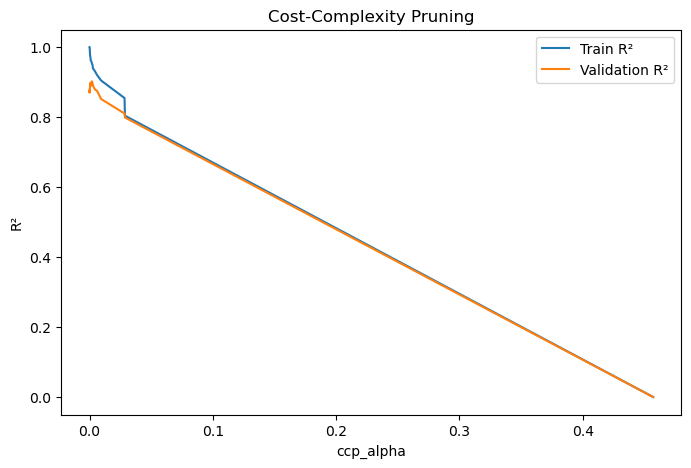

In [5]:
train_scores = [t.score(X_train, y_train) for t in trees]
val_scores = [t.score(X_val, y_val) for t in trees]

plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, train_scores, label="Train R²")
plt.plot(ccp_alphas, val_scores, label="Validation R²")
plt.xlabel("ccp_alpha")
plt.ylabel("R²")
plt.legend()
plt.title("Cost-Complexity Pruning")
plt.show()

# Custom Decision Tree

In [6]:
import numpy as np
from collections import Counter

def entropy(y):
    counts = Counter(y)
    n = len(y)
    return -sum((c/n) * np.log2(c/n) for c in counts.values())


def mse(y):
    mean = np.mean(y)
    return np.mean((y - mean) ** 2)

class TreeNode:
    def __init__(self, *, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # prediction at leaf

class BaseDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, verbose=True):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.verbose = verbose
        self.root = None
    def _best_split(self, X, y):
        best_gain = -np.inf
        best_feature = None
        best_threshold = None

        parent_impurity = self._impurity(y)

        n_samples, n_features = X.shape

        for feature in range(n_features):
            values = X[:, feature]

            # Check if feature is categorical
            is_categorical = isinstance(values[0], str)

            if is_categorical:
                categories = set(values)
                for cat in categories:
                    left_idx = values == cat
                    right_idx = values != cat
                    gain = self._information_gain(y, left_idx, right_idx, parent_impurity)

                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = cat

            else:
                unique_vals = np.unique(values)
                thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2

                for t in thresholds:
                    left_idx = values <= t
                    right_idx = values > t
                    gain = self._information_gain(y, left_idx, right_idx, parent_impurity)

                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = t

        return best_feature, best_threshold, best_gain
    def _information_gain(self, y, left_idx, right_idx, parent_impurity):
        n = len(y)
        n_l, n_r = np.sum(left_idx), np.sum(right_idx)

        if n_l == 0 or n_r == 0:
            return 0

        child_impurity = (
            (n_l / n) * self._impurity(y[left_idx]) +
            (n_r / n) * self._impurity(y[right_idx])
        )

        return parent_impurity - child_impurity

    def _build_tree(self, X, y, depth):
        if self.verbose:
            print(f"\nDepth {depth} | Samples {len(y)}")

        # Stopping conditions
        if (depth >= self.max_depth or
            len(y) < self.min_samples_split or
            self._is_pure(y)):

            value = self._leaf_value(y)
            if self.verbose:
                print(f"Leaf created with value: {value}")
            return TreeNode(value=value)

        feature, threshold, gain = self._best_split(X, y)

        if gain <= 0:
            value = self._leaf_value(y)
            if self.verbose:
                print(f"No gain → Leaf with value: {value}")
            return TreeNode(value=value)

        if self.verbose:
            print(f"Split: Feature {feature}, Threshold {threshold}, Gain {gain:.4f}")

        if isinstance(threshold, str):
            left_idx = X[:, feature] == threshold
        else:
            left_idx = X[:, feature] <= threshold

        right_idx = ~left_idx

        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return TreeNode(feature=feature, threshold=threshold, left=left, right=right)
        
    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value

        if isinstance(node.threshold, str):
            if x[node.feature] == node.threshold:
                return self._predict_one(x, node.left)
            else:
                return self._predict_one(x, node.right)
        else:
            if x[node.feature] <= node.threshold:
                return self._predict_one(x, node.left)
            else:
                return self._predict_one(x, node.right)

    def predict(self, X):
        return np.array([self._predict_one(x, self.root) for x in X])


In [7]:
class DecisionTreeClassifier(BaseDecisionTree):
    def _impurity(self, y):
        return entropy(y)

    def _leaf_value(self, y):
        return Counter(y).most_common(1)[0][0]

    def _is_pure(self, y):
        return len(set(y)) == 1


In [8]:
class DecisionTreeRegressor(BaseDecisionTree):
    def _impurity(self, y):
        return mse(y)

    def _leaf_value(self, y):
        return np.mean(y)

    def _is_pure(self, y):
        return np.var(y) == 0


In [9]:
X = np.array([
    [5.1, "red"],
    [4.9, "blue"],
    [6.2, "red"],
    [5.9, "green"],
    [6.0, "blue"]
], dtype=object)

y = np.array([0, 0, 1, 1, 1])

tree = DecisionTreeClassifier(max_depth=3, verbose=True)
tree.fit(X, y)

preds = tree.predict(X)
print(preds)



Depth 0 | Samples 5
Split: Feature 0, Threshold 5.5, Gain 0.9710

Depth 1 | Samples 2
Leaf created with value: 0

Depth 1 | Samples 3
Leaf created with value: 1
[0 0 1 1 1]


In [10]:
import numpy as np
import math
from collections import Counter, defaultdict

def entropy(y):
    counts = Counter(y)
    n = len(y)
    return -sum((c / n) * math.log2(c / n) for c in counts.values())

def gini(y):
    counts = Counter(y)
    n = len(y)
    return 1 - sum((c / n) ** 2 for c in counts.values())

def mse(y):
    mean = np.mean(y)
    return np.mean((y - mean) ** 2)

class TreeNode:
    def __init__(self, *, feature=None, threshold=None, left=None, right=None,
                 value=None, impurity=None, n_samples=None, gain=0.0):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.impurity = impurity
        self.n_samples = n_samples
        self.gain = gain

class BaseDecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2,
                 criterion="gini", task="classification", verbose=True):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.task = task
        self.verbose = verbose
        self.root = None
        self.feature_importances_ = defaultdict(float)

        if task == "classification":
            self._impurity = entropy if criterion == "entropy" else gini
        else:
            self._impurity = mse

    def fit(self, X, y):
        self.n_features_ = X.shape[1]
        self.root = self._grow_tree(X, y, depth=0)
        total_gain = sum(self.feature_importances_.values())
        if total_gain > 0:
            for k in self.feature_importances_:
                self.feature_importances_[k] /= total_gain

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold, best_splits = None, None, None
        parent_impurity = self._impurity(y)

        for feature in range(X.shape[1]):
            values = X[:, feature]
            unique_vals = np.unique(values)

            if values.dtype.kind in {"U", "S", "O"}:
                for v in unique_vals:
                    left_idx = values == v
                    right_idx = ~left_idx
                    gain = self._information_gain(y, left_idx, right_idx, parent_impurity)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = v
                        best_splits = (left_idx, right_idx)
            else:
                sorted_vals = np.sort(unique_vals.astype(float))
                thresholds = (sorted_vals[:-1] + sorted_vals[1:]) / 2
                for t in thresholds:
                    left_idx = values.astype(float) <= t
                    right_idx = values.astype(float) > t
                    gain = self._information_gain(y, left_idx, right_idx, parent_impurity)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = t
                        best_splits = (left_idx, right_idx)

        return best_feature, best_threshold, best_splits, best_gain

    def _information_gain(self, y, left_idx, right_idx, parent_impurity):
        n = len(y)
        n_l, n_r = np.sum(left_idx), np.sum(right_idx)
        if n_l == 0 or n_r == 0:
            return 0
        child_impurity = (
            (n_l / n) * self._impurity(y[left_idx]) +
            (n_r / n) * self._impurity(y[right_idx])
        )
        return parent_impurity - child_impurity

    def _grow_tree(self, X, y, depth):
        node = TreeNode(
            impurity=self._impurity(y),
            n_samples=len(y),
            value=self._leaf_value(y)
        )

        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return node

        feature, threshold, splits, gain = self._best_split(X, y)

        if feature is None or gain <= 0:
            return node

        left_idx, right_idx = splits
        self.feature_importances_[feature] += gain * len(y)

        if self.verbose:
            print(f"Depth {depth} | Split: X[{feature}] <= {threshold} | Gain: {gain:.4f}")

        node.feature = feature
        node.threshold = threshold
        node.gain = gain
        node.left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        node.right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        node.value = None
        return node

    def _leaf_value(self, y):
        if self.task == "classification":
            return Counter(y).most_common(1)[0][0]
        return np.mean(y)

    def predict(self, X):
        return np.array([self._predict_row(x, self.root) for x in X])

    def _predict_row(self, x, node):
        if node.feature is None:
            return node.value
        val = x[node.feature]
        if isinstance(node.threshold, str):
            if val == node.threshold:
                return self._predict_row(x, node.left)
            else:
                return self._predict_row(x, node.right)
        else:
            if float(val) <= node.threshold:
                return self._predict_row(x, node.left)
            else:
                return self._predict_row(x, node.right)

    def cost_complexity_prune(self, alpha):
        def prune(node):
            if node.left is None or node.right is None:
                return node, node.impurity * node.n_samples, 1

            left, left_err, left_leaves = prune(node.left)
            right, right_err, right_leaves = prune(node.right)

            subtree_err = left_err + right_err
            leaf_err = node.impurity * node.n_samples

            if leaf_err + alpha <= subtree_err:
                return TreeNode(
                    value=node.value,
                    impurity=node.impurity,
                    n_samples=node.n_samples
                ), leaf_err, 1

            node.left, node.right = left, right
            return node, subtree_err, left_leaves + right_leaves

        self.root, _, _ = prune(self.root)

class DecisionTreeClassifier(BaseDecisionTree):
    def __init__(self, max_depth=10, min_samples_split=2,
                 criterion="gini", verbose=True):
        super().__init__(max_depth, min_samples_split,
                         criterion, task="classification", verbose=verbose)

class DecisionTreeRegressor(BaseDecisionTree):
    def __init__(self, max_depth=10, min_samples_split=2, verbose=True):
        super().__init__(max_depth, min_samples_split,
                         criterion="mse", task="regression", verbose=verbose)


In [11]:
import numpy as np

# -------------------------------
# Classification example
# -------------------------------

# Mixed dataset: continuous + categorical
X_cls = np.array([
    [25, "Red"],
    [30, "Blue"],
    [45, "Red"],
    [35, "Blue"],
    [22, "Green"],
    [28, "Green"],
    [40, "Red"],
    [50, "Blue"]
], dtype=object)

y_cls = np.array(["No", "No", "Yes", "Yes", "No", "No", "Yes", "Yes"])

clf = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=2,
    criterion="entropy",
    verbose=True
)

clf.fit(X_cls, y_cls)

print("\nPredictions (classification):")
print(clf.predict(X_cls))

print("\nFeature importances (classification):")
print(dict(clf.feature_importances_))

# Cost-complexity pruning
clf.cost_complexity_prune(alpha=0.01)

print("\nPredictions after pruning:")
print(clf.predict(X_cls))


# -------------------------------
# Regression example
# -------------------------------

# Dataset: continuous + categorical
X_reg = np.array([
    [1.0, "Low"],
    [2.0, "Low"],
    [3.0, "Medium"],
    [4.0, "Medium"],
    [5.0, "High"],
    [6.0, "High"]
], dtype=object)

y_reg = np.array([10, 12, 18, 22, 30, 35], dtype=float)

reg = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=2,
    verbose=True
)

reg.fit(X_reg, y_reg)

print("\nPredictions (regression):")
print(reg.predict(X_reg))

print("\nFeature importances (regression):")
print(dict(reg.feature_importances_))

# Cost-complexity pruning
reg.cost_complexity_prune(alpha=1.0)

print("\nPredictions after pruning:")
print(reg.predict(X_reg))


Depth 0 | Split: X[1] <= Green | Gain: 0.3113
Depth 1 | Split: X[0] <= 25 | Gain: 0.3167
Depth 2 | Split: X[0] <= 30 | Gain: 0.7219

Predictions (classification):
['No' 'No' 'Yes' 'Yes' 'No' 'No' 'Yes' 'Yes']

Feature importances (classification):
{1: np.float64(0.31127812445913283), 0: np.float64(0.6887218755408672)}

Predictions after pruning:
['No' 'No' 'Yes' 'Yes' 'No' 'No' 'Yes' 'Yes']
Depth 0 | Split: X[1] <= High | Gain: 64.2222
Depth 1 | Split: X[0] <= 5.0 | Gain: 6.2500
Depth 1 | Split: X[1] <= Low | Gain: 20.2500
Depth 2 | Split: X[0] <= 1.0 | Gain: 1.0000
Depth 2 | Split: X[0] <= 3.0 | Gain: 4.0000

Predictions (regression):
[10. 12. 18. 22. 30. 35.]

Feature importances (regression):
{1: np.float64(0.9539720422775315), 0: np.float64(0.04602795772246847)}

Predictions after pruning:
[10. 12. 18. 22. 30. 35.]
